# Assignment 4 (ML-II)

# Mall Customers Dataset (Example 1)

## Wali Ullah (09745)

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

In [3]:
# Load Data
def load_data(file_name):
    def readcsv(file_name):
        return pd.read_csv(file_name)
    def readexcel(file_name):
        return pd.read_excel(file_name)
    func_map = {
        "csv": readcsv,
        "xlsx": readexcel,
    }
    
    # default reader = readcsv
    reader = func_map.get("csv")
    
    for k,v in func_map.items():
        if file_name.endswith(k):
            reader = v
            break
    return reader(file_name)


## Data Set 

In [4]:
FILE_NAME = "Mall_Customers.csv"
#FILE_NAME = "banksim_adj.csv"
#LABEL_COL = "fraud"
df = load_data(FILE_NAME)
display(df.head())
print(df.shape)
print(df.dtypes)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


(200, 5)
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


In [5]:
df.isnull().any().any()

False

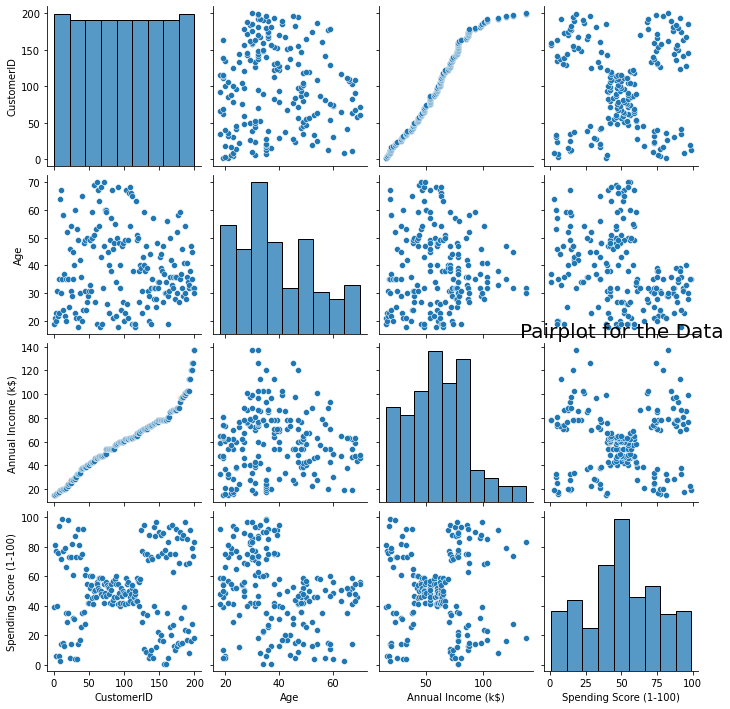

In [6]:
sns.pairplot(df)
plt.title('Pairplot for the Data', fontsize = 20)
plt.show()

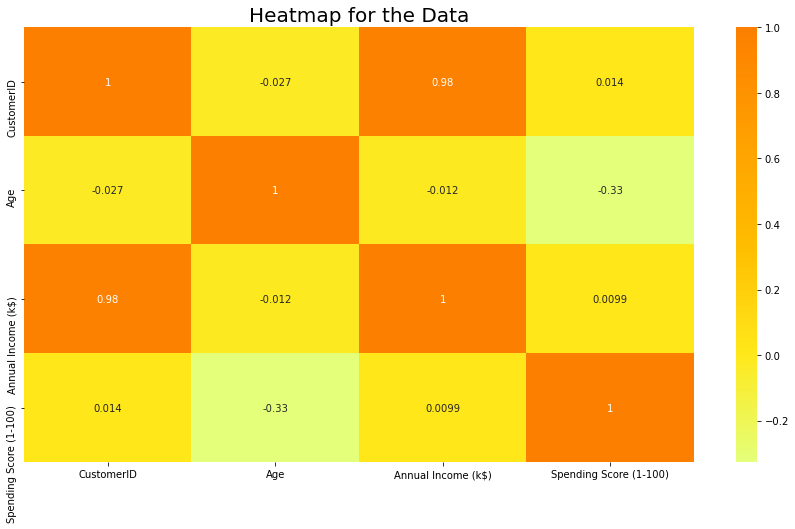

In [7]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap for the Data', fontsize = 20)
plt.show()

The Above Graph for Showing the correlation between the different attributes of the Mall Customer Segementation Dataset, This Heat map reflects the most correlated features with Orange Color and least correlated features with yellow color.

We can clearly see that these attributes do not have good correlation among them, that's why we will proceed with all of the features.

In [8]:
df.Gender[df.Gender == 'Male'] = 1
df.Gender[df.Gender == 'Female'] = 0
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40
...,...,...,...,...,...
195,196,0,35,120,79
196,197,0,45,126,28
197,198,1,32,126,74
198,199,1,32,137,18


# Clustering Analysis

In [9]:
X = df.iloc[:, [1,2,3, 4]].values
# let's check the shape of x
print(X.shape)
X

(200, 4)


array([[1, 19, 15, 39],
       [1, 21, 15, 81],
       [0, 20, 16, 6],
       [0, 23, 16, 77],
       [0, 31, 17, 40],
       [0, 22, 17, 76],
       [0, 35, 18, 6],
       [0, 23, 18, 94],
       [1, 64, 19, 3],
       [0, 30, 19, 72],
       [1, 67, 19, 14],
       [0, 35, 19, 99],
       [0, 58, 20, 15],
       [0, 24, 20, 77],
       [1, 37, 20, 13],
       [1, 22, 20, 79],
       [0, 35, 21, 35],
       [1, 20, 21, 66],
       [1, 52, 23, 29],
       [0, 35, 23, 98],
       [1, 35, 24, 35],
       [1, 25, 24, 73],
       [0, 46, 25, 5],
       [1, 31, 25, 73],
       [0, 54, 28, 14],
       [1, 29, 28, 82],
       [0, 45, 28, 32],
       [1, 35, 28, 61],
       [0, 40, 29, 31],
       [0, 23, 29, 87],
       [1, 60, 30, 4],
       [0, 21, 30, 73],
       [1, 53, 33, 4],
       [1, 18, 33, 92],
       [0, 49, 33, 14],
       [0, 21, 33, 81],
       [0, 42, 34, 17],
       [0, 30, 34, 73],
       [0, 36, 37, 26],
       [0, 20, 37, 75],
       [0, 65, 38, 35],
       [1, 24, 38, 92]

In [10]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X=X_scaled
X

array([[1.        , 0.01923077, 0.        , 0.3877551 ],
       [1.        , 0.05769231, 0.        , 0.81632653],
       [0.        , 0.03846154, 0.00819672, 0.05102041],
       [0.        , 0.09615385, 0.00819672, 0.7755102 ],
       [0.        , 0.25      , 0.01639344, 0.39795918],
       [0.        , 0.07692308, 0.01639344, 0.76530612],
       [0.        , 0.32692308, 0.02459016, 0.05102041],
       [0.        , 0.09615385, 0.02459016, 0.94897959],
       [1.        , 0.88461538, 0.03278689, 0.02040816],
       [0.        , 0.23076923, 0.03278689, 0.7244898 ],
       [1.        , 0.94230769, 0.03278689, 0.13265306],
       [0.        , 0.32692308, 0.03278689, 1.        ],
       [0.        , 0.76923077, 0.04098361, 0.14285714],
       [0.        , 0.11538462, 0.04098361, 0.7755102 ],
       [1.        , 0.36538462, 0.04098361, 0.12244898],
       [1.        , 0.07692308, 0.04098361, 0.79591837],
       [0.        , 0.32692308, 0.04918033, 0.34693878],
       [1.        , 0.03846154,

# K-Mean

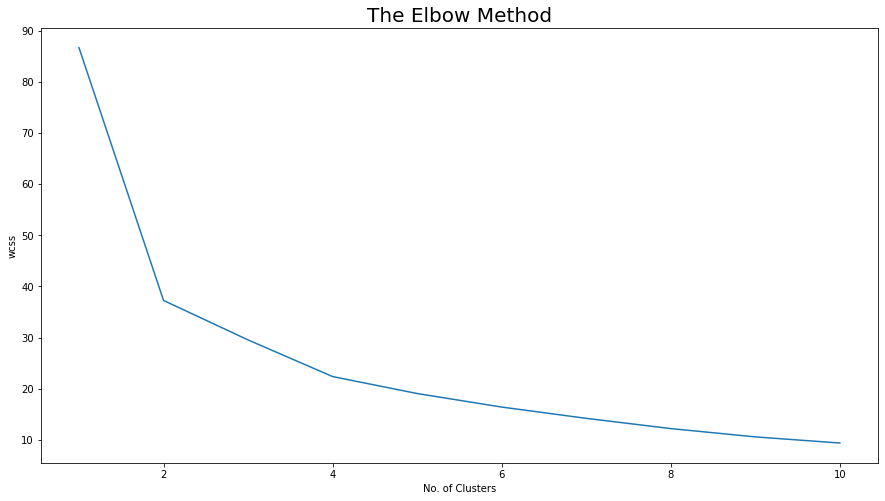

In [11]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(X)
    wcss.append(km.inertia_)   
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

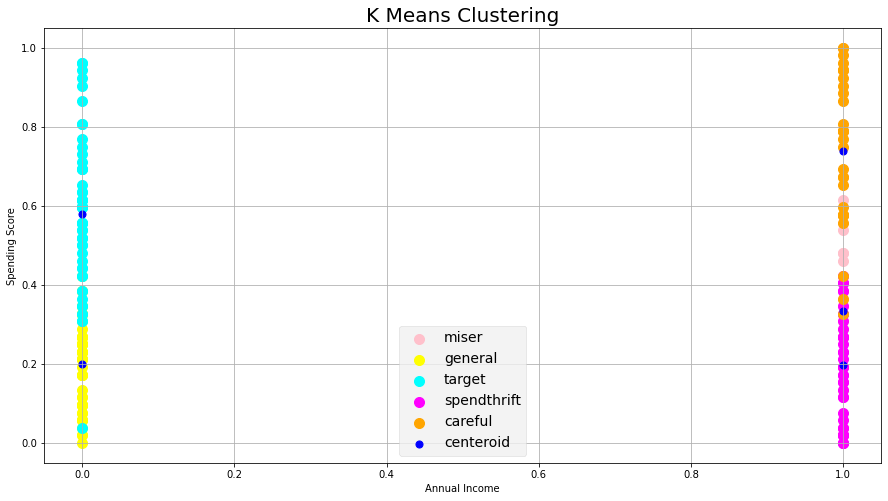

In [12]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(X)
plt.scatter(X[y_means == 0, 0], X[y_means == 0, 1], s = 100, c = 'pink', label = 'miser')
plt.scatter(X[y_means == 1, 0], X[y_means == 1, 1], s = 100, c = 'yellow', label = 'general')
plt.scatter(X[y_means == 2, 0], X[y_means == 2, 1], s = 100, c = 'cyan', label = 'target')
plt.scatter(X[y_means == 3, 0], X[y_means == 3, 1], s = 100, c = 'magenta', label = 'spendthrift')
plt.scatter(X[y_means == 4, 0], X[y_means == 4, 1], s = 100, c = 'orange', label = 'careful')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')
plt.style.use('fivethirtyeight')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()

This Clustering Analysis gives us a very clear insight about the different segments of the customers in the Mall. There are clearly Five segments of Customers namely Miser, General, Target, Spendthrift, Careful based on their Annual Income and Spending Score which are reportedly the best factors/attributes to determine the segments of a customer in a Mall.

# Mini-Batch K-Means

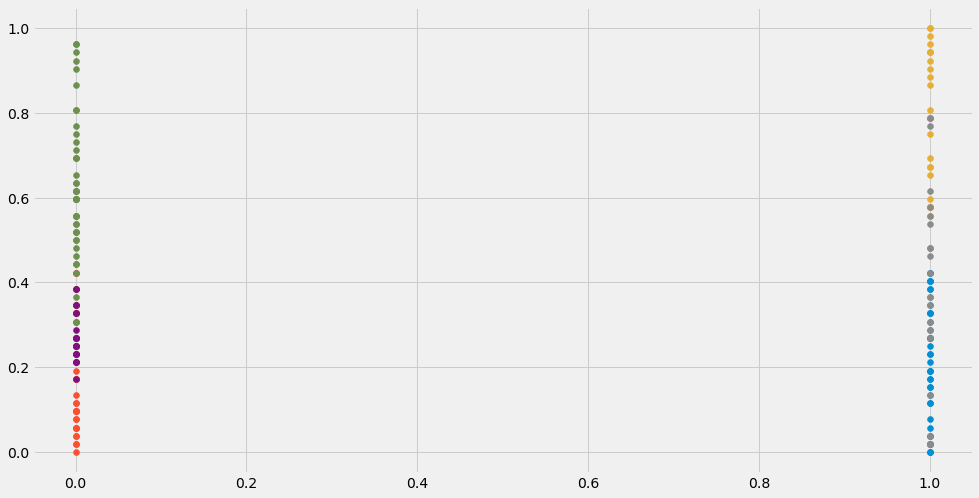

In [13]:
# mini-batch k-means clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import MiniBatchKMeans
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = MiniBatchKMeans(n_clusters=6)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

The Mini-Batch K-Means results are similar almost with the K-Mean clustering.

# Hierarchial Clustering

**Using Dendrograms to find the no. of Optimal Clusters**

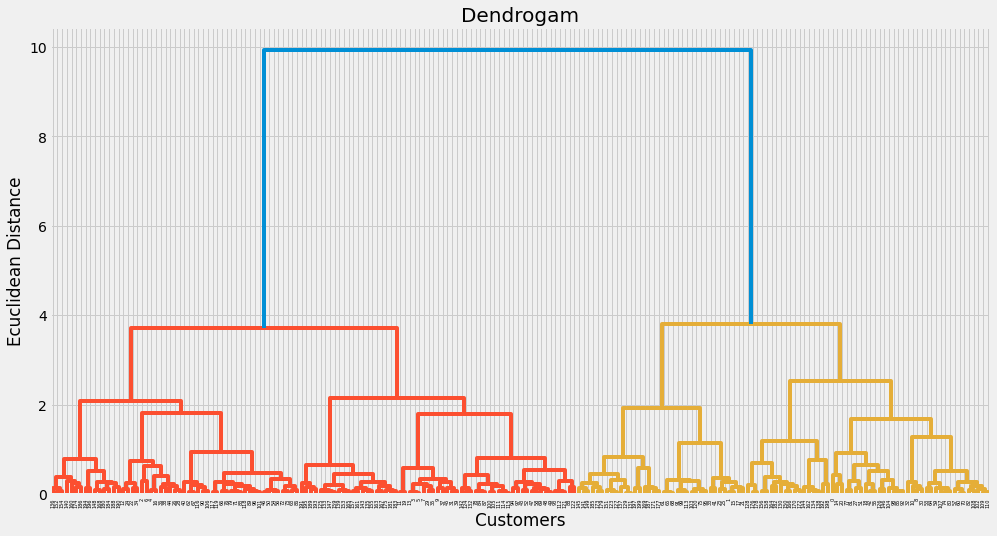

In [15]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

# Visualizing the Clusters of Hierarchial Clustering

In [16]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(X)

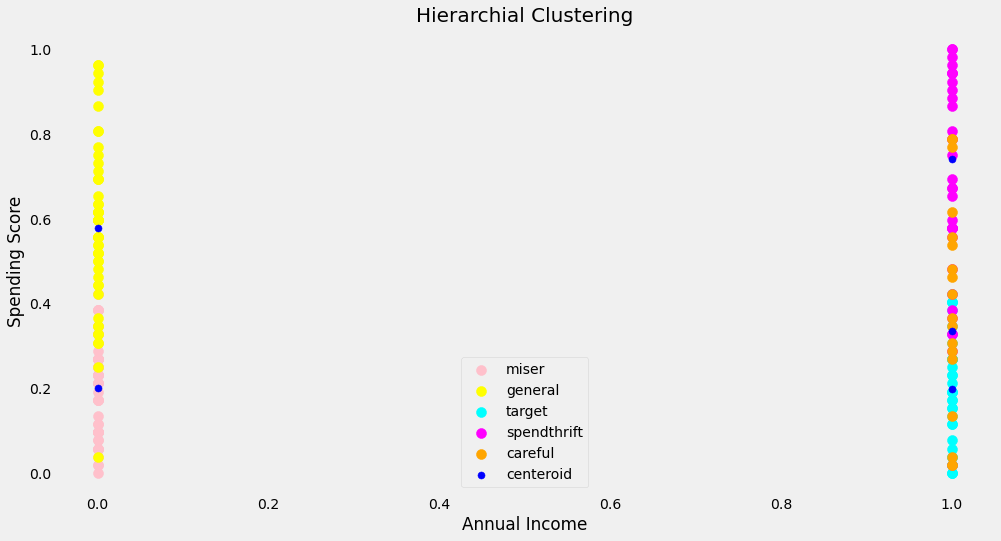

In [17]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'pink', label = 'miser')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'yellow', label = 'general')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'cyan', label = 'target')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'magenta', label = 'spendthrift')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'orange', label = 'careful')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')
plt.style.use('fivethirtyeight')
plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()

# DBSCAN Clustering

In [18]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X)

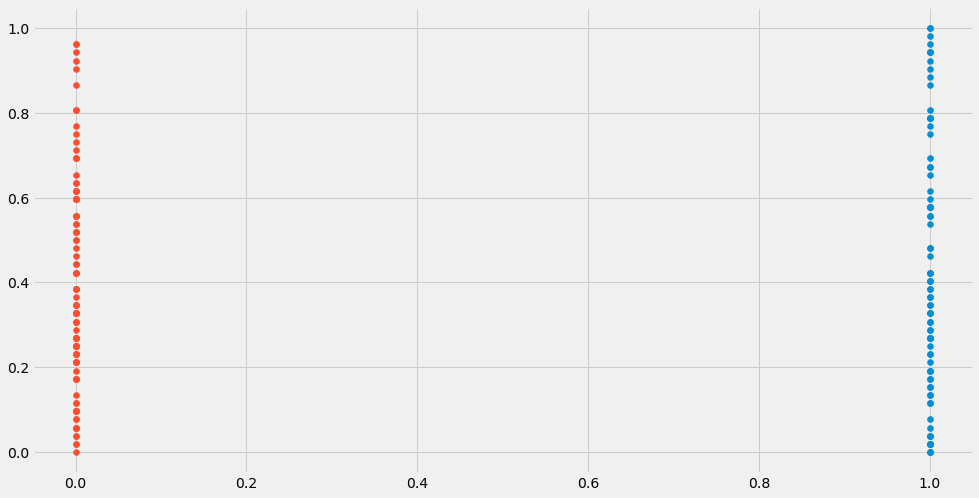

In [19]:
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1).fit(X)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [20]:
# Get the cluster labels (aka numbers)
pred_labels = db.labels_
# Count the total number of clusters
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
# Print model results
print(f'Estimated number of clusters: {n_clusters_}')

Estimated number of clusters: 2


In [21]:
import sklearn.metrics as metrics

In [22]:
# Print model results
print(f'Silhouette Coefficient: {metrics.silhouette_score(X, pred_labels):0.3f}')

Silhouette Coefficient: 0.519


In [23]:
# Get sample counts in each cluster 
counts = np.bincount(pred_labels[pred_labels>=0])
print(counts)

[ 88 112]


In [25]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X)
# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

In [26]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')

Estimated number of clusters: 2


It devides the entire sample in two clusters

# Optics Clustering

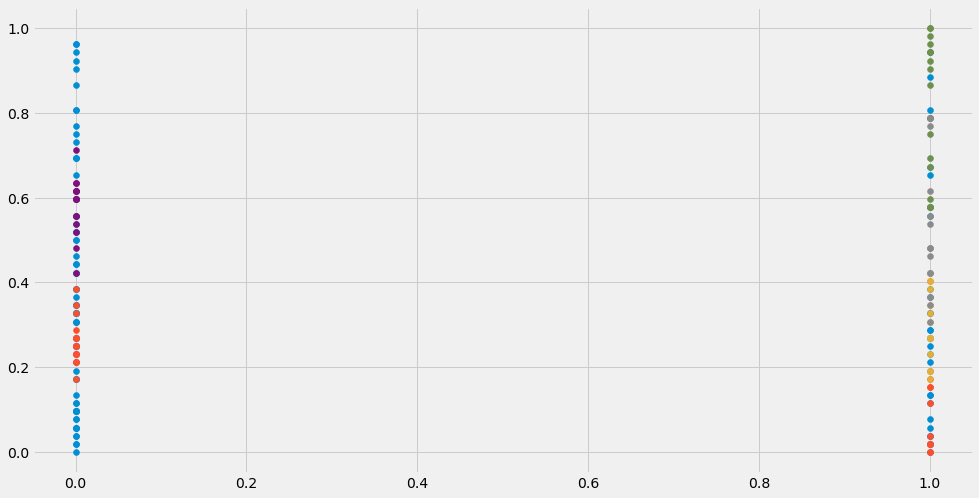

In [27]:
# optics clustering
from numpy import unique
from numpy import where
from sklearn.cluster import OPTICS
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = OPTICS(eps=0.8, min_samples=10)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [28]:
# Get the cluster labels (aka numbers)
pred_labels = model.labels_
# Count the total number of clusters
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
# Print model results
print(f'Estimated number of clusters: {n_clusters_}')

Estimated number of clusters: 7


In [29]:
# Get sample counts in each cluster 
counts = np.bincount(pred_labels[pred_labels>=0])
print(counts)

[10 15 20 11 16 19 17]


In [30]:
# Initialize and fit the DBscan model
model = OPTICS(eps=0.8, min_samples=10, n_jobs=-1).fit(X)
# Obtain the predicted labels and calculate number of clusters
pred_labels = model.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

In [31]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')

Estimated number of clusters: 7


The OPTICS devides the sample into seven clusters

# Spectral Clustering

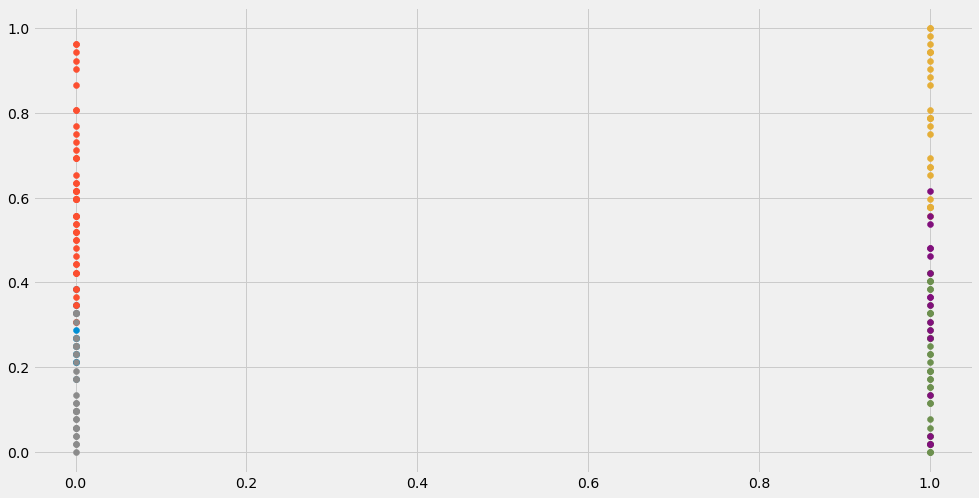

In [32]:
# spectral clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = SpectralClustering(n_clusters=6)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [33]:
clusters = unique(yhat)
clusters 

array([0, 1, 2, 3, 4, 5])

It devides the sample into six clusters, which seems reasonable.

# Gaussian Mixture Clustering Model

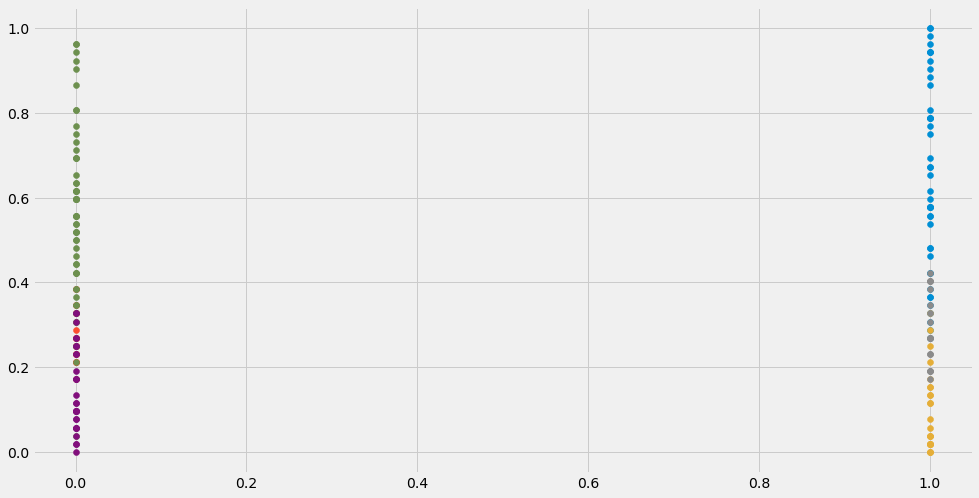

In [34]:
# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define the model
model = GaussianMixture(n_components=6)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [35]:
clusters = unique(yhat)
clusters

array([0, 1, 2, 3, 4, 5], dtype=int64)

It devides the sample into six clusters, which seems reasonable.

# BIRCH Clustering

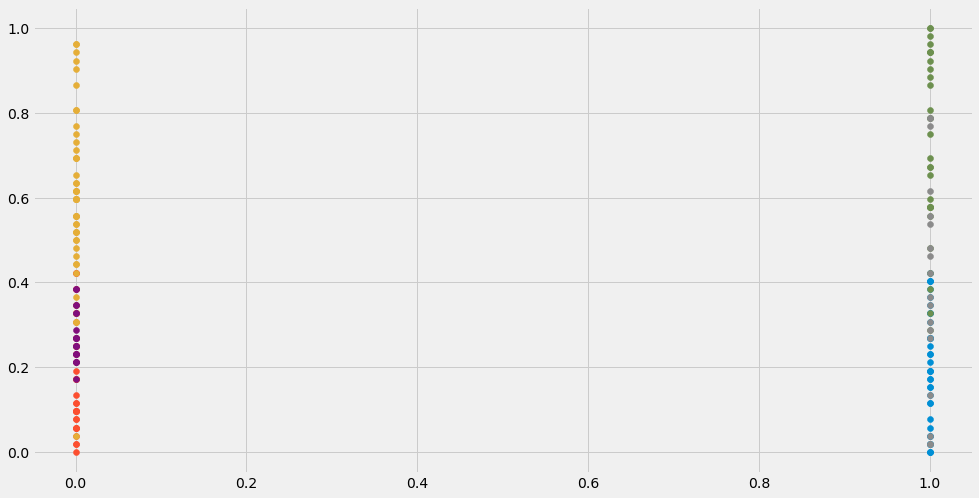

In [36]:
# birch clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = Birch(threshold=0.01, n_clusters=6)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [37]:
clusters = unique(yhat)
clusters

array([0, 1, 2, 3, 4, 5], dtype=int64)

# Agglomerative Clustering

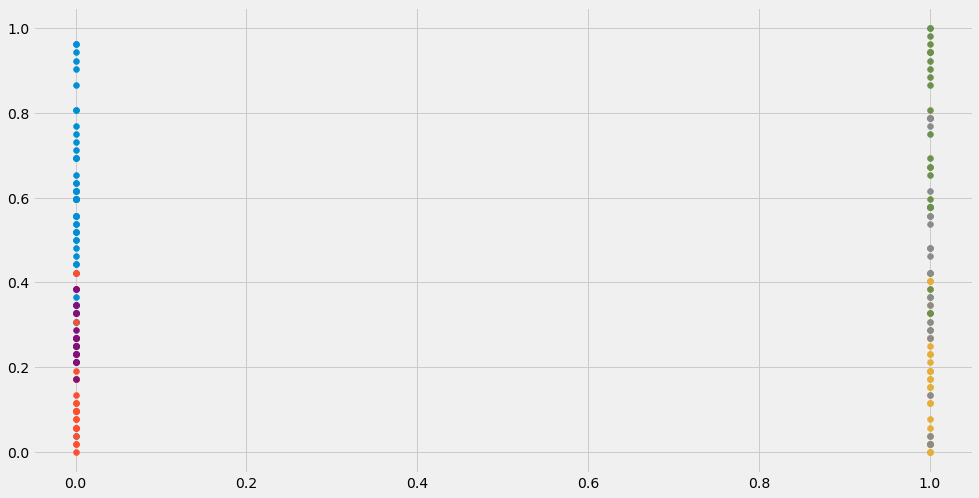

In [38]:
# agglomerative clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = AgglomerativeClustering(n_clusters=6)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [39]:
clusters = unique(yhat)
clusters

array([0, 1, 2, 3, 4, 5], dtype=int64)

# Affinity Propagation Clustering

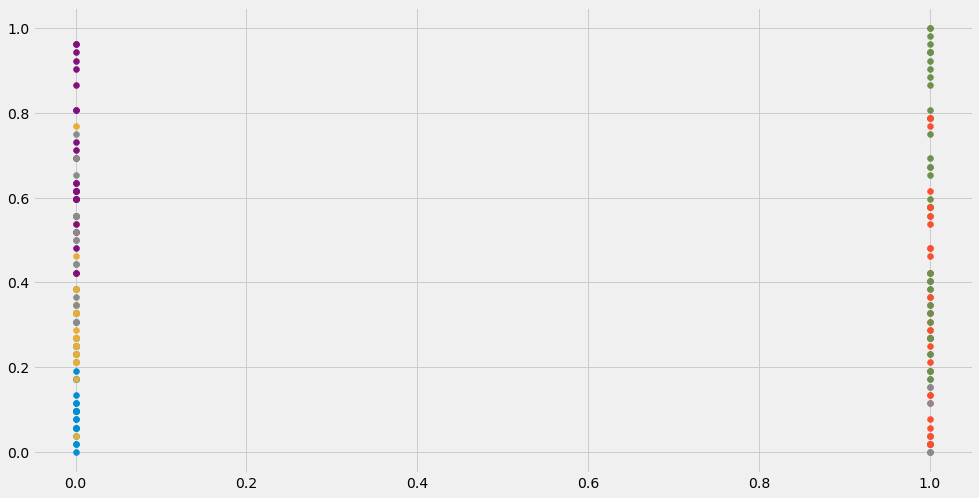

In [40]:
# affinity propagation clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [41]:
clusters = unique(yhat)
clusters

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

It puts the entire sample in one clusters.

# Clustering Alg. Comparison

In [42]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

def clustering_alg(X,y): 
    algorithms = []
    algorithms.append(KMeans(n_clusters=6, init = 'k-means++', max_iter = 300, n_init = 10, random_state=1))
    algorithms.append(AgglomerativeClustering(n_clusters=6))
    algorithms.append(AffinityPropagation(damping=0.9))
    algorithms.append(SpectralClustering(n_clusters=6, random_state=1,
                                     affinity='nearest_neighbors'))
    algorithms.append(DBSCAN(eps=0.9, min_samples=2, n_jobs=1).fit(X))
    algorithms.append(OPTICS(eps=0.8, min_samples=10))
    algorithms.append(GaussianMixture(n_components=6))
    algorithms.append(MiniBatchKMeans(n_clusters=6))
    algorithms.append(Birch(threshold=0.01, n_clusters=6))
    algorithms.append(AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage = 'ward'))
    data = []
    for algo in algorithms:
        algo.fit(X)
        data.append(({
            'ARI': metrics.adjusted_rand_score(y, algo.labels_),
            'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_,
                                                 average_method='arithmetic'),
            'Homogenity': metrics.homogeneity_score(y, algo.labels_),
            'Completeness': metrics.completeness_score(y, algo.labels_),
            'V-measure': metrics.v_measure_score(y, algo.labels_),
            'Silhouette': metrics.silhouette_score(X, algo.labels_)
        }))

    results = pd.DataFrame(data=data1, columns=['ARI', 'AMI', 'Homogenity', 'Completeness', 'V-measure','Silhouette'],
                       index=['K-means', 'Agglomerative','Affinity', 
                              'Spectral','DBSCAN','OPTICS',
                              'GaussianMixture',
                              'MiniBatchKMeans','Birch',
                             'AgglomerativeClustering'])
    return results

If in the sample the actual label is availible, then we can apply the above algrotham to evaluate and compare the predicted class and actual class of each row in terms of 'ARI', 'AMI', 'Homogenity', 'Completeness', 'V-measure','Silhouette', which are the various measures of comparison

# Conclusion

The above results shows that the K-mean and Hirarchical clustering give almost similar results and seems better than the remaining clustering algrotham.
This Clustering Analysis gives us a very clear insight about the different segments of the customers in the Mall. There are clearly Five segments of Customers namely Miser, General, Target, Spendthrift, Careful based on their Annual Income and Spending Score which are reportedly the best factors/attributes to determine the segments of a customer in a Mall.